In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('final.csv') 


In [3]:
data = data.dropna()

In [4]:
X = data.drop(['MB'], axis=1)  
y = data['MB']  

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% for training, 30% for testing + validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)  # Split 30% into 10% validation and 20% test

In [6]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [7]:
def specificity(y_true, y_pred):
    y_pred = tf.round(tf.nn.sigmoid(y_pred))  
    true_negatives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 0), 'float'))
    false_positives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 1), 'float'))
    
    specificity = true_negatives / (true_negatives + false_positives + tf.keras.backend.epsilon())
    return specificity

In [8]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(tf.nn.sigmoid(y_pred))  
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Logistic regression layer
])

In [10]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[
                  'accuracy',
                  tf.keras.metrics.AUC(name='auc'),
                  f1_score
                      ]
             )


In [11]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    verbose=1,
    class_weight=class_weight_dict
)


Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 0.6164 - accuracy: 0.4473 - auc: 0.7957 - f1_score: 0.2365 - val_loss: 0.7009 - val_accuracy: 0.5215 - val_auc: 0.9118 - val_f1_score: 0.2246
Epoch 2/10
143/143 [==============================] - 0s 745us/step - loss: 0.5008 - accuracy: 0.6742 - auc: 0.9393 - f1_score: 0.2338 - val_loss: 0.5855 - val_accuracy: 0.7323 - val_auc: 0.9569 - val_f1_score: 0.2246
Epoch 3/10
143/143 [==============================] - 0s 713us/step - loss: 0.4278 - accuracy: 0.7928 - auc: 0.9616 - f1_score: 0.2327 - val_loss: 0.4803 - val_accuracy: 0.8385 - val_auc: 0.9663 - val_f1_score: 0.2246
Epoch 4/10
143/143 [==============================] - 0s 689us/step - loss: 0.3770 - accuracy: 0.8502 - auc: 0.9677 - f1_score: 0.2333 - val_loss: 0.4270 - val_accuracy: 0.8692 - val_auc: 0.9731 - val_f1_score: 0.2246
Epoch 5/10
143/143 [==============================] - 0s 648us/step - loss: 0.3392 - accuracy: 0.8770 - auc: 0.9725 - f1_score: 0.

In [12]:
# Get predictions for training
y_train_pred = model.predict(X_train)
y_train_pred_class = tf.round(y_train_pred)  # Convert probabilities to class predictions

# Generate confusion matrix for training
cm_train = confusion_matrix(y_train, y_train_pred_class)
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
sensitivity_train = tp_train / (tp_train + fn_train)
specificity_train = tn_train / (tn_train + fp_train)

print(f"Training Sensitivity: {sensitivity_train:.2f}")
print(f"Training Specificity: {specificity_train:.2f}")

# Get predictions for validation
y_val_pred = model.predict(X_val)
y_val_pred_class = tf.round(y_val_pred)  # Convert probabilities to class predictions

# Generate confusion matrix for validation
cm_val = confusion_matrix(y_val, y_val_pred_class)
tn_val, fp_val, fn_val, tp_val = cm_val.ravel()
sensitivity_val = tp_val / (tp_val + fn_val)
specificity_val = tn_val / (tn_val + fp_val)

print(f"Validation Sensitivity: {sensitivity_val:.2f}")
print(f"Validation Specificity: {specificity_val:.2f}")


143/143 [==============================] - 0s 325us/step
Training Sensitivity: 0.96
Training Specificity: 0.90
21/21 [==============================] - 0s 356us/step
Validation Sensitivity: 0.96
Validation Specificity: 0.90


In [13]:
history = model.evaluate(
    X_test, 
    y_test
)


41/41 [==============================] - 0s 475us/step - loss: 0.2828 - accuracy: 0.9062 - auc: 0.9825 - f1_score: 0.2237


In [14]:
# Get predictions for test data
y_test_pred = model.predict(X_test)
y_test_pred_class = tf.round(y_test_pred)  # Convert probabilities to class predictions

# Generate confusion matrix for test
cm_test = confusion_matrix(y_test, y_test_pred_class)
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

print(f"Test Sensitivity: {sensitivity_test:.2f}")
print(f"Test Specificity: {specificity_test:.2f}")


41/41 [==============================] - 0s 328us/step
Test Sensitivity: 0.95
Test Specificity: 0.90


In [15]:
import shap
background_data = shap.kmeans(X_train, 10)  # Use 10 clusters, adjust as necessary
explainer = shap.KernelExplainer(model.predict, background_data)
shap_values = explainer.shap_values(X_test)

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1301 [00:00<?, ?it/s]

685/685 [==============================] - 0s 492us/step


In [16]:
shap_values_reshaped = np.squeeze(shap_values)  # Removes the last dimension
print(shap_values_reshaped.shape)

(1301, 81)


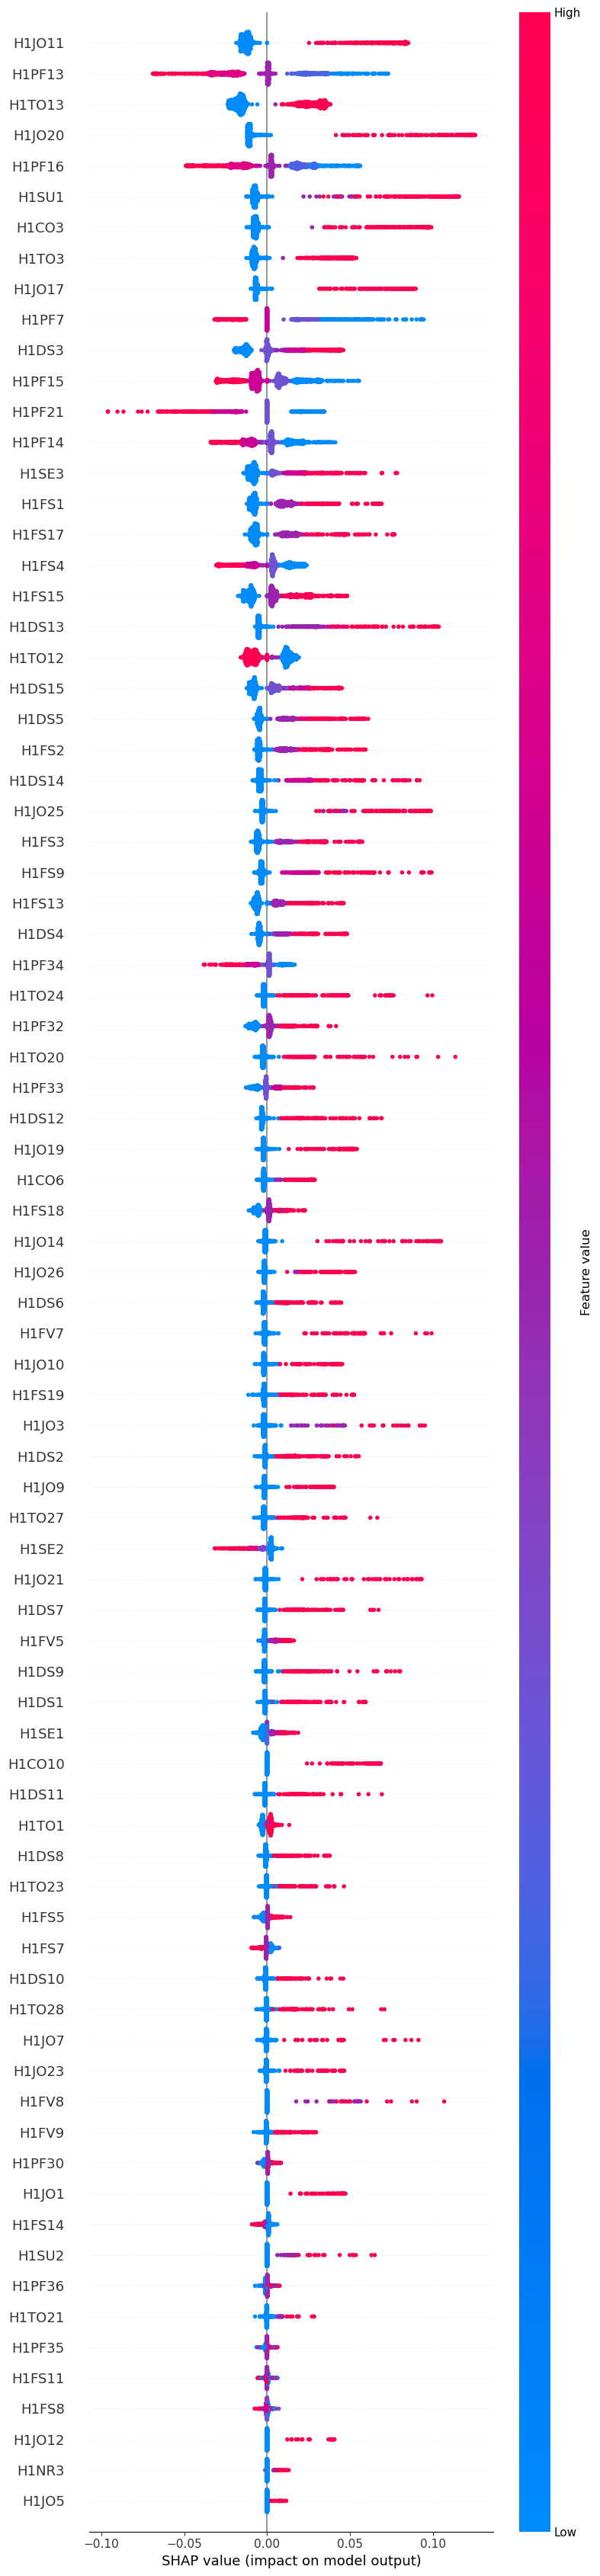

In [17]:
shap.summary_plot(shap_values_reshaped, X_test, max_display=X_test.shape[1])